## Пункт 2: Подготовка датасета

In [12]:
import pandas as pd

In [13]:
df = pd.read_csv('data_new.csv')
df.drop(df.columns[0], axis=1, inplace=True)

### Извлечение данных из текстовых признаков

In [15]:
import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

russian_stopwords = stopwords.words("russian")

mystem = Mystem()

def preprocess_text(text):
    text = text.lower()
    text = ' '.join(text.split(', ')[1:len(text.split(', '))-1])

    tokens = mystem.lemmatize(text)
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and len(token)>=3 \
              and token.strip() not in punctuation \
              and token.isdigit()==False]
    text = " ".join(tokens)
    return text

In [16]:
df['Обработка названия'] = df['Название продукта'].apply(preprocess_text)

,Название продукта,Бренд,Срок годности,Количество в упаковке,Единица измерения,Вес упаковки,Цена,Категория,Длина упаковки,Ширина упаковки,Высота упаковки,Обработка названия,Код категории
0,"Primaforce, Порошок D-аспарагиновой кислоты, б...",Primaforce,2026-10-01,300,г,0.38,3622,Аминокислоты,14.7,9.3,9.1,порошок аспарагиновый кислота добавка,1
1,"Nutricost, D-аспарагиновая кислота, без вкусов...",Nutricost,2025-11-01,300,г,0.39,3346,Аминокислоты,14.9,9.3,9.3,аспарагиновый кислота вкусовой добавка,1
2,"Bluebonnet Nutrition, Nucleotide Complex, РНК ...",Bluebonnet Nutrition,2026-08-01,60,шт.,0.22,7653,Аминокислоты,11.2,6.1,6.1,nucleotide complex рнк днк,1
3,"Swanson, L-гистидин, 500 мг, 60 растительных к...",Swanson,2025-05-01,60,шт.,0.07,2362,Аминокислоты,8.8,4.6,4.6,гистидин,1
4,"Allergy Research Group, Триметилглицин ТМГ, 10...",Allergy Research Group,2025-07-01,100,шт.,0.11,4502,Аминокислоты,6.1,6.1,11.2,триметилглицин тмг,1


### Фильтрация и перевод в нужные форматы

In [20]:
# Перевод срока годности в формат даты
df['Срок годности'] = pd.to_datetime(df['Срок годности'], format='%m.%Y', errors='coerce')

# Перевод цены из распаршенного формата в числовой
df = df.dropna(subset=['Цена'])

def format_price(text):
    text = str(text)
    text = ''.join(text[:-1].split(' '))
    return text

df['Цена'] = df['Цена'].str.replace(r'\s+|₽', '', regex=True).astype(int)

# Фильтрация выбросов по весу
df = df.loc[df['Вес упаковки'] < 2]

### Построение признаков из категориальных переменных

In [21]:
categories = {}
for key,value in enumerate(df[u'Категория'].unique()):
    categories[value] = key + 1

df['Код категории'] = df[u'Категория'].map(categories)

In [23]:
df.to_csv("preprocessed_data.csv")

### Построение графиков

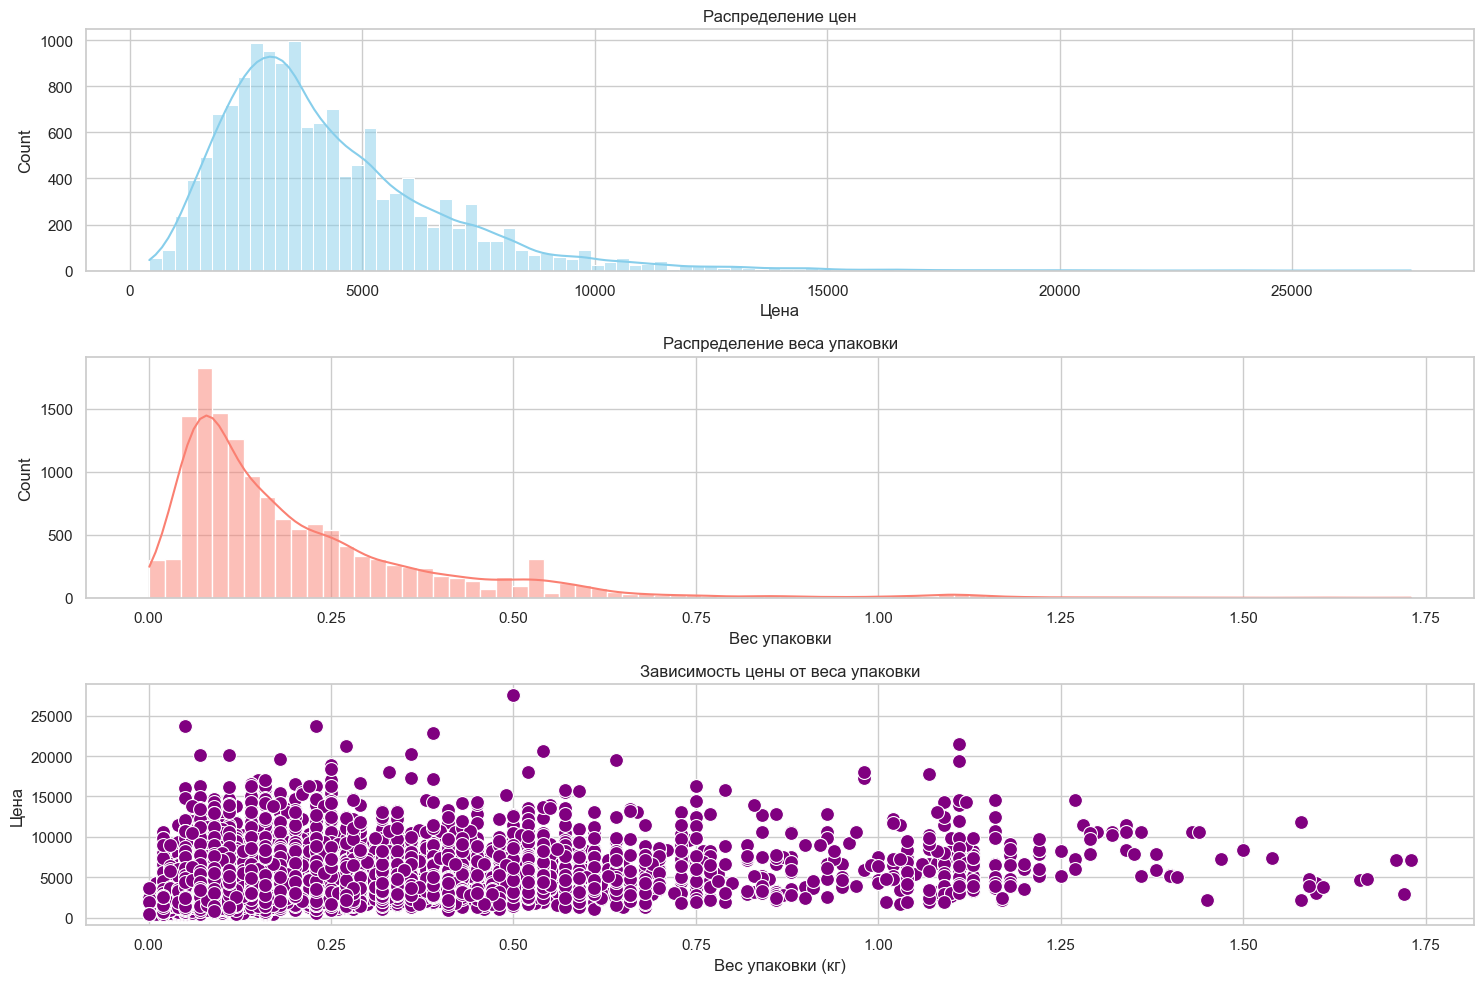

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(15, 10))

# Гистограммы для распределения цены и веса упаковки
plt.subplot(3, 1, 1)
sns.histplot(df['Цена'], bins=100, kde=True, color='skyblue')
plt.title("Распределение цен")

plt.subplot(3, 1, 2)
sns.histplot(df['Вес упаковки'], bins=80, kde=True, color='salmon')
plt.title("Распределение веса упаковки")

plt.subplot(3, 1, 3)
sns.scatterplot(x='Вес упаковки', y='Цена', data=df, color='purple', s=100)
plt.title("Зависимость цены от веса упаковки")
plt.xlabel("Вес упаковки (кг)")
plt.ylabel("Цена")

plt.tight_layout()
plt.show()

## Пункт 3-8: Реализация решения (Байесовский классификатор)

In [73]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from imblearn.pipeline import Pipeline

### Разделение дата-сета на обучающую, тестовую и валидационную выборки

In [74]:
x = df['Обработка названия']
y = df['Категория']

X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.4, stratify=y, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

### Обучение модели и поиск лучшего гиперпараметра \alpha, оценка метрик

In [82]:
text_clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()), 
    ('clf', MultinomialNB())
])

param_grid = {
    'clf__alpha': np.arange(0.05, 0.01, -0.001)
}

# Подбор гиперпараметра \alpha на тренировочной выборке
grid_search = GridSearchCV(text_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Оптимальный параметр и точность на валидации
print("Лучший параметр alpha:", grid_search.best_params_)
print("Лучшее значение accuracy на кросс-валидации:", grid_search.best_score_)

# Оценка на валидационной выборке с лучшим alpha
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)
print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred, zero_division=0))

# Подбор гиперпараметра на тестовой выборке
# В реальных задачах это делать не рекомендуется, но для эксперимента
grid_search_test = GridSearchCV(text_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_test.fit(X_test, y_test)

# Оптимальный параметр и точность на тестовой выборке
print("Лучший параметр alpha на тестовой выборке:", grid_search_test.best_params_)
print("Лучшее значение accuracy на тестовой выборке:", grid_search_test.best_score_)

# Оценка модели с тестовым alpha на тестовой выборке
best_model_test = grid_search_test.best_estimator_
y_test_pred = best_model_test.predict(X_test)
print("\nTest Classification Report with Test alpha:\n", classification_report(y_test, y_test_pred, zero_division=0))

Лучший параметр alpha: {'clf__alpha': np.float64(0.039999999999999994)}
Лучшее значение accuracy на кросс-валидации: 0.8403630298154658

Validation Classification Report:
                         precision    recall  f1-score   support

          Аминокислоты       0.94      0.92      0.93       271
         Антиоксиданты       0.88      0.85      0.87       320
              Витамины       0.71      0.88      0.79       586
  Волосы, кожа и ногти       0.87      0.76      0.81        80
      Глаза, уши и нос       0.82      0.36      0.50        25
                 Грибы       0.92      0.83      0.87        78
    Деятельность мозга       0.69      0.49      0.57        74
      Женское здоровье       0.78      0.70      0.74       155
      Здоровье мужчины       0.87      0.71      0.78       109
    Зелень и суперфуды       0.89      0.87      0.88       197
Кости, суставы и хрящи       0.87      0.88      0.87       210
         Микроэлементы       0.88      0.83      0.86      

### Собственная реализация модели

In [81]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, classification_report
from bayes import CustomNaiveBayes  # Собственная реализация

x = df['Обработка названия']
y = df['Категория']

X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

count_vect = CountVectorizer(ngram_range=(1, 2))
X_train_counts = count_vect.fit_transform(X_train)
X_val_counts = count_vect.transform(X_val)
X_test_counts = count_vect.transform(X_test)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_val_tfidf = tfidf_transformer.transform(X_val_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

# Подбор оптимального alpha на валидационной выборке
best_alpha_val = 0
best_score_val = 0

for alpha in np.arange(0.05, 0, -0.001):
    custom_nb = CustomNaiveBayes(alpha=alpha)
    custom_nb.fit(X_train_tfidf, y_train)
    
    y_val_pred = custom_nb.predict(X_val_tfidf)
    score = accuracy_score(y_val, y_val_pred)
    
    if score > best_score_val:
        best_score_val = score
        best_alpha_val = alpha

print("Лучшее значение alpha на валидационной выборке:", best_alpha_val)
print("Лучший результат на валидационной выборке:", best_score_val)

# Оценка модели с best_alpha на тестовой выборке
best_model_val = CustomNaiveBayes(alpha=best_alpha_val)
best_model_val.fit(X_train_tfidf, y_train)

y_test_pred_val = best_model_val.predict(X_test_tfidf)
print("\nTest Score with Validation alpha:", accuracy_score(y_test, y_test_pred_val))
print("\nTest Classification Report with Validation alpha:\n", classification_report(y_test, y_test_pred_val, zero_division=0))

# Подбор оптимального alpha на тестовой выборке (экспериментально)
best_alpha_test = 0
best_score_test = 0

for alpha in np.arange(0.05, 0, -0.001):
    custom_nb_test = CustomNaiveBayes(alpha=alpha)
    custom_nb_test.fit(X_train_tfidf, y_train)
    
    y_test_pred = custom_nb_test.predict(X_test_tfidf)
    score_test = accuracy_score(y_test, y_test_pred)
    
    if score_test > best_score_test:
        best_score_test = score_test
        best_alpha_test = alpha

print("Лучшее значение alpha на тестовой выборке:", best_alpha_test)
print("Лучший результат на тестовой выборке:", best_score_test)

Лучшее значение alpha на валидационной выборке: 0.030999999999999986
Лучший результат на валидационной выборке: 0.8359972202918694

Test Score with Validation alpha: 0.8366921473245309

Test Classification Report with Validation alpha:
                         precision    recall  f1-score   support

          Аминокислоты       0.93      0.91      0.92       271
         Антиоксиданты       0.86      0.88      0.87       320
              Витамины       0.70      0.90      0.79       585
  Волосы, кожа и ногти       0.93      0.72      0.81        79
      Глаза, уши и нос       0.79      0.46      0.58        24
                 Грибы       0.90      0.78      0.84        79
    Деятельность мозга       0.73      0.45      0.55        74
      Женское здоровье       0.81      0.67      0.74       156
      Здоровье мужчины       0.85      0.66      0.74       109
    Зелень и суперфуды       0.87      0.89      0.88       197
Кости, суставы и хрящи       0.90      0.86      0.88     